<a href="https://colab.research.google.com/github/revanth7667/STAT-663_Codes/blob/main/Notebooks/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install datasets

In [2]:
%%capture

#Importing the Required Pacakges and Libraries

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Dataset
from datasets import load_dataset

#tensorflow
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

#other
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# loading the Dataset and viewing it's structure
dataset = load_dataset("cifar10")
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

Text(0.5, 1.0, '0')

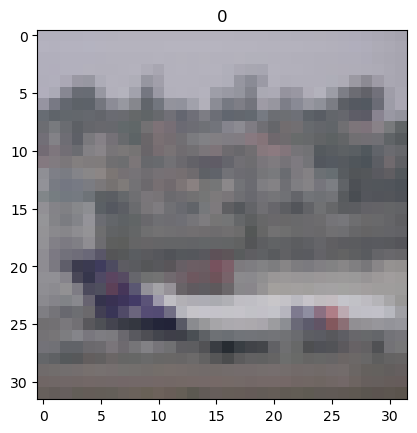

In [4]:
# Viewing Sample Image from Training Data
element = next(iter(dataset["train"]))
plt.imshow(element["img"])
plt.title(element["label"])

In [28]:
tst = (np.array(element["img"])[None, ...] / 255.0).flatten().reshape(-1, 3072)
tst.shape

(1, 3072)

## Raw Models

In [31]:
X_train = np.array(
    [(np.array(i)[None, ...] / 255.0).flatten() for i in dataset["train"]["img"][:]]
)  # .reshape(-1, 32 * 32 * 3)
y_train = np.array(dataset["train"]["label"][:])

In [35]:
X_test = np.array(
    [(np.array(i)[None, ...] / 255.0).flatten() for i in dataset["test"]["img"][:]]
)  # .reshape(-1, 32 * 32 * 3)
y_test = np.array(dataset["test"]["label"][:])

In [33]:
X_train.shape

(50000, 3072)

### Decision Trees

In [34]:
# Trainig Model with Train Data
model_rf_raw = RandomForestClassifier(n_estimators=100)

model_rf_raw.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
# Predicting the Test Data
y_pred = model_rf_raw.predict(X_test)

In [37]:
# Checking the Accuracy of the Model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.4647
[[557  40  55  25  35  19  23  28 158  60]
 [ 36 547  21  28  24  26  40  35  64 179]
 [103  42 335  77 133  75 125  55  23  32]
 [ 49  53  72 261  88 171 148  65  26  67]
 [ 57  21 139  58 387  45 154  98  24  17]
 [ 37  23 101 159  79 377  75  94  25  30]
 [  6  31  75  78 111  56 571  20   8  44]
 [ 52  41  48  64 111  84  42 442  22  94]
 [ 89  94  17  22  18  38  10  16 616  80]
 [ 46 160  16  38  19  26  18  37  86 554]]


In [38]:
model_lr_raw = LogisticRegression(
    max_iter=500, multi_class="multinomial", solver="lbfgs", random_state=42
)
model_lr_raw.fit(X_train, y_train)

/Users/revanth/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

In [39]:
y_pred = model_lr_raw.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.3904
[[488  39  53  40  22  34  21  56 176  71]
 [ 64 449  38  36  32  44  34  50  73 180]
 [100  38 290  92 114  88 127  81  44  26]
 [ 44  44 101 243  61 204 146  51  40  66]
 [ 62  27 134  69 280 102 165 103  33  25]
 [ 34  43 105 181  85 313  77  80  44  38]
 [ 21  34  81 137  94  97 451  45  14  26]
 [ 43  45  72  73  94  90  39 427  34  83]
 [153  71  26  26  15  44  17  20 523 105]
 [ 79 183  17  36  28  26  50  67  74 440]]


## ResNet

In [42]:
# Load a pretrained model
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,  # take any input shape, not just 224x224
    weights="imagenet",  # use the imagenet pretrained model
    pooling="avg",  # use global average pooling to get a 2048 vector from our image
)

In [45]:
from tensorflow.keras.applications.resnet50 import preprocess_input


def preprocess(img):
    processed_img = preprocess_input(  # ResNet has its own preprocesser
        tf.image.resize(  # Images need to be in (224, 224) dimension
            np.array(img), (224, 224)  # Turn PIL image object into array
        )
    )[None]
    return processed_img


# use resnet to get the embeddings
X_train_resnet = np.array(
    [model.predict(preprocess(i)) for i in dataset["train"]["img"][:100]]
)

1/1 [==============================] - 0s 53ms/step


In [49]:
X_train_resnet.reshape(-1, 2048).shape

(100, 2048)

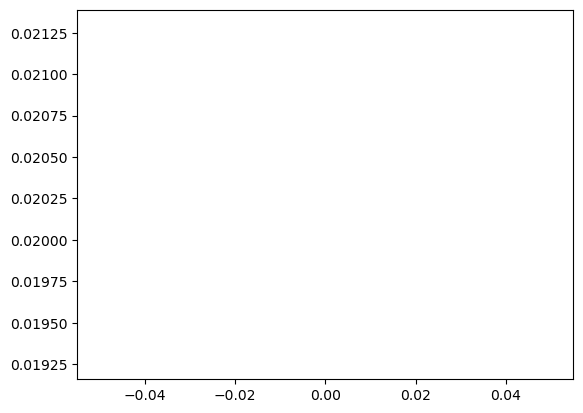

In [51]:
# Visualize embedding
plt.plot(X_train_resnet[0][:, 0])

In [ ]:
# @title Lab work
# Loop over the remaining CIFAR10 dataset to produce 2048 embeddings of the image
# Use a logistic regression or random foreset to try and classify these features as before
# Try to use batching to speed up the generation of your features, what is batching?
# Steps:
# 1. Your input data is a 32x32x3 image. You have 50,000 images total so your input dimension is
#    50000 x (32 x 32 x 3). Or 50000 rows and 3072 (which is (32 x 32 x 3)) pixels.
#    Previously we use pixels as features of or Logistic Regression and Random Forest
# 2. The ResNet50 model transforms our pixels into "2048" feature embedding so now it is
#    50000 rows and 2048 columns of "features"
# 3. Use these new features to train a simple logistic regression and random forest model as we did in the scikit learn example
#    https://colab.research.google.com/drive/1KUperg8lvb3gYBPzP6sbZd89Ft8rDbYG#scrollTo=_bAd38A0N73w